# Рекомендация тарифов

В этом кейсе мы рассмотрим поведение клиентов оператора мобильой связи Мегалайн. Нам нужно, на основании данных клиентов перешедших на тарифы Смарт и Ультра, обучить модель, которая будет предсказывать какой из этих тарифов лучше предложить клиентам, которые пользуются архивными тарифами.

Наша цель подобрать модель для рекомендаций c максимально большим значением *accuracy*, большим, чем 0.75%. 

**План работ**
1) Знакомство с данными.
2) Разделение исходных данных на обучающую, валидационную и тестовую выборки.
3) Исследование качества разных моделей. Краткое описание выводов исследования.
4) Проверка качества модели на тестовой выборке.
5) Проверка модели на вменяемость.

\* Предобработка проводиться не будет, так как предоставленный нам датафрейм уже прошел через этот этап. 

**Описание данных** \
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).



## Откроем и изучим файл

In [1]:
# Сделаем необходимые импорты
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Сделаем удобные настройки вывода

# Зададим значение для генератора псевдослучайных чисел
np.random.seed(12345)

# Сбросим ограничение на число столбцов
pd.set_option('display.max_columns', None)

# Сбросим ограничение на число строк
pd.set_option('display.max_rows', None)

# Зададим формат отображения вещественных чисел в Pandas
pd.set_option('display.float_format', '{:,.2f}'.format)

# Сбросим ограничение на число символов в записи
pd.set_option('display.max_colwidth', None)

# Не показываем предупреждение
warnings.filterwarnings('ignore')

In [3]:
# Загрузим файл в переменную df
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('users_behavior.csv')

In [4]:
# Выведем десять случайных строк датафрейма
df.sample(10, random_state=1234)

,calls,minutes,messages,mb_used,is_ultra
1758,77.00,496.76,0.00,"17,765.34",0
730,36.00,259.50,8.00,"7,417.14",0
1851,188.00,"1,290.22",74.00,"28,289.60",1
978,66.00,443.83,0.00,"17,672.29",0
2815,40.00,253.36,19.00,"18,842.65",0
576,72.00,498.89,71.00,"17,450.90",1
2378,65.00,489.11,18.00,"10,739.04",0
876,57.00,335.55,28.00,"17,364.21",0
1996,88.00,697.53,48.00,"21,408.38",0
2823,6.00,42.99,9.00,"12,782.92",0


In [5]:
# Посмотрим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице пять признаков, первые четыре представлены вещественными числами, целевой признак (колонка is_ultra) категориальный, имеет тип данных int.

In [6]:
# Напишем функцию для вывода основных статистик набораа данных

def dataframe_information(data):
    """Функция для вывода основных статистик набора данных"""
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg',
               'mean', 'std', 'min', 'max', 'outliners', 'duplicates']
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
        column_negative_values, column_mean, column_std, column_min, column_max, outliers, duplicates_sum = \
            None, None, None, None, None, None, None
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = ((column_na_values + column_zero_values) / data.shape[0]) * 100
        column_unique_values = len(data[column_name].unique())
        duplicates_sum = len(data.loc[data.duplicated() > 0, column_name])
        if data[column_name].dtype != 'object':
            column_negative_values = data[column_name][data[column_name] < 0].count()
            column_mean = data[column_name].mean()
            column_std = data[column_name].std()
            column_min = data[column_name].min()
            column_max = data[column_name].max()
            q1 = data[column_name].quantile(0.25)
            q3 = data[column_name].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = len(data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)])

        # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values,
                        column_zero_values, column_na_zero_rate, column_unique_values,
                        column_negative_values, column_mean, column_std,
                        column_min, column_max, outliers, duplicates_sum])

    # формируем набор данных
    df_res = pd.DataFrame(data=df_data, columns=df_cols)

    return df_res


# Применим функцию на датафрейм
dataframe_information(df)


,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,calls,float64,0,40,1.24,184,0,63.04,33.24,0.00,244.00,62,0
1,minutes,float64,0,40,1.24,3144,0,438.21,234.57,0.00,"1,632.06",61,0
2,messages,float64,0,497,15.46,180,0,38.28,36.15,0.00,224.00,91,0
3,mb_used,float64,0,11,0.34,3203,0,"17,207.67","7,570.97",0.00,"49,745.73",77,0
4,is_ultra,int64,0,2229,69.35,2,0,0.31,0.46,0.00,1.00,0,0


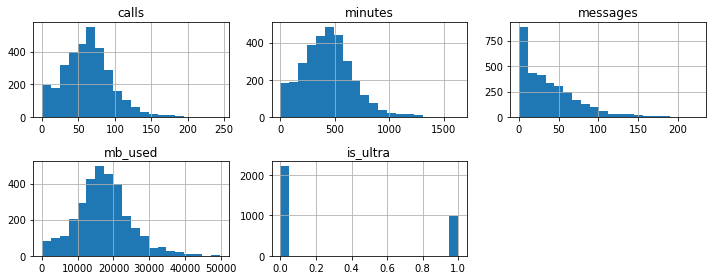

In [7]:
# Построим гистограммы каждого признака
df.hist(layout=(2, 3), figsize=(10, 4), bins=20)
plt.tight_layout()
plt.show()


В данных больше половины пользователей использующих тариф "Смарт" (69.35%). Большая часть данных имеет нормальное распределение. Учитывая средние и форму распределений, а также выбросы в облассти нуля, можно сделать вывод, что наиболее популярной опцией для клиентов является доступ в интернет, на втором месте - возможность совершать звонки, и менее востребованный функционал - отправка сообщений.

#### Вывод

Данные имеют 3214 записей (строк) и 5 признаков (колонок). Первые четыре атрибута количественные, представлены вещественными числами, целевой признак (колонка is_ultra) категориальный, имеет тип данных int. \
В данных больше половины пользователей использующих тариф "Смарт" (69.35%). Большая часть данных имеет нормальное распределение. Учитывая средние и форму распределений, а также выбросы в облассти нуля, можно сделать вывод, что наиболее популярной опцией для клиентов является доступ в интернет, на втором месте - возможность совершать звонки, и менее востребованный функционал - отправка сообщений.

## Разбейте данные на выборки

#### Разделение данных на валидационную, тестовую и обучающую выборки

In [8]:
# Разделим датасет на три части:
# 60% в обучающую и по 20% в валидационную и тестовые выборки
df_train, df_valid = train_test_split(df, test_size=0.20, random_state=1234)
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=1234)

# Выведем результат
print(f'Размер обучающей выборки - {df_train.shape}.')
print(f'Размер валидационной выборки - {df_valid.shape}.')
print(f'Размер тестовой выборки - {df_test.shape}.')

Размер обучающей выборки - (1928, 5).
Размер валидационной выборки - (643, 5).
Размер тестовой выборки - (643, 5).


In [9]:
# Проверим соответствие размеров
(
    'Размер трех выборок в сумме соотвествует размеру исходного датасета - '
    f'{df.shape[0] == df_train.shape[0] + df_valid.shape[0] + df_test.shape[0]}'
)

'Размер трех выборок в сумме соотвествует размеру исходного датасета - True'

Посмотрим, насколько равномерно распределен целевой признак в каждой выборке.

In [10]:
df_train['is_ultra'].value_counts() / df_train['is_ultra'].value_counts().sum() * 100

0   69.87
1   30.13
Name: is_ultra, dtype: float64

In [11]:
df_valid['is_ultra'].value_counts() / df_valid['is_ultra'].value_counts().sum() * 100

0   67.19
1   32.81
Name: is_ultra, dtype: float64

In [12]:
df_test['is_ultra'].value_counts() / df_test['is_ultra'].value_counts().sum() * 100

0   69.98
1   30.02
Name: is_ultra, dtype: float64

Распределение получилось более-менее равномерное.

#### Вынесем у каждой выборки целевой признак в отдельную переменную.

In [13]:
# Вынесем в отдельную переменную target_, целевой признак.
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

# Проверим корректность разделения на одной выборке
features_test.head()

,calls,minutes,messages,mb_used
2889,37.00,211.53,11.00,"14,912.46"
1404,32.00,187.52,47.00,"19,373.91"
627,73.00,540.96,12.00,"13,501.00"
2084,41.00,296.80,70.00,"17,280.85"
3154,69.00,488.40,36.00,"14,165.05"


In [14]:
target_test.head()

2889    0
1404    0
627     0
2084    0
3154    0
Name: is_ultra, dtype: int64

#### Вывод

Мы разделили датафрейм на три части в пропорциях 3:1:1, в переменные для обучения, тестов и валидации соответственно. \
Далее мы каждую выборку разделили на две переменные - с целевым признаком ('is_ultra') и остальными.

## Исследуем модели

В этом разделе мы обучим три вида моделей - дерево решений, случайный лес и логистическую регрессию. \
Наша цель - выявить модель с самым большим значением accuracy (наибольшей долей правильных ответов).

#### Дерево решений

In [15]:
best_model_tree = None
best_depth = 0
best_result = 0

# Возьмем максимульную глубину дерева - 15
for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=1234, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_model_tree = model
        best_result = result
        best_depth = depth
print(f'Accuracy наилучшей модели на валидационной выборке: {best_result:.3f}')
print(f'Оптимальная глубина дерева - {best_depth}')

Accuracy наилучшей модели на валидационной выборке: 0.788
Оптимальная глубина дерева - 3


#### Случайный лес

In [16]:
best_model_forest = None
best_est = 0
best_depth = 0
best_result = 0

# Возьмем максимальное количество деревьев - 100, с шагом 10 и глубину от 1 до 16 с шагом 2
for est in range(10, 101, 10):
    for depth in range(1, 16, 2):
        model = RandomForestClassifier(random_state=1234, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model_forest = model
            best_result = result
            best_est = est
            best_depth = depth
print(f'Accuracy наилучшей модели на валидационной выборке: {best_result:.3f}')
print(f'Оптимальное количество деревьев - {best_est}')
print(f'Наиболее результативная глубина - {best_depth}')

Accuracy наилучшей модели на валидационной выборке: 0.823
Оптимальное количество деревьев - 20
Наиболее результативная глубина - 11


#### Логистическая регрессия

In [17]:
best_model_log = None
best_iter = 0
best_result = 0

# Возьмем максимульное количество итераций -от 50 до 300, с шагом 10
for itr in range(50, 300, 10):
    model = LogisticRegression(solver='lbfgs', max_iter=itr)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model_log = model
        best_result = result
        best_iter = itr
print(f'Accuracy наилучшей модели на валидационной выборке: {best_result:.3f}')
print(f'Оптимальное количество итераций - {best_iter}')

Accuracy наилучшей модели на валидационной выборке: 0.737
Оптимальное количество итераций - 60


In [18]:
model = LogisticRegression(solver='lbfgs')
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)
print(f'Accuracy модели логистической регрессии {result:.3f}')

Accuracy модели логистической регрессии 0.733


#### Вывод

Мы обучили три вида моделей: дерево решений, случайный лес и логистическую регрессию. Поссчитали accuracy на валидационных выборках и выявили, что для нашего набора данных лучшие результаты показывает модель случайного леса.

## Проверим модель на тестовой выборке

В прошлом этапе, для нашего набора данных лучшие результаты показала модель Случайного леса, ее и будем проверять на тестовой выборке.

In [19]:
predict = best_model_forest.predict(features_test)
print(f'Accuracy модели случайного леса на тестовой выборке: {accuracy_score(target_test, predict):.3f}')

Accuracy модели случайного леса на тестовой выборке: 0.804


На тестовой выборке эта модель показала на 1.9% результат хуже, чем на валидационной. Расхождение незначительное.

#### Вывод

Мы проверили лучшую модель (случайного леса) на тестовой выборке, она показала accuracy на 1.9% меньший, чем на валидационной выборке (82.3%), что незначительно. Результат все еще лучший по сравнению с остальными двумя моделями. Нам удалось достичь acceracy не менее 75%.

## Проверка модели на адекватность

Чтобы проверить модель на адекватность, сравним accuracy модели случайный лес с гипотетической моделью, которая всегда предсказывает наиболее часто встречающуюся категорию. \
Наиболее частый тариф - '0' (тариф 'Смарт'), в нашем датафрейме он встречается в 69.35% случаев, т.е. accuracy такой модели будет примерно равно 70%. 

Accuracy случайного леса, для нашей выборки составляет 80%,  что выше чем 70%, таким образом наша модель адекватна.


## Общий вывод

В этом кейсе мы рассматривали поведение клиентов оператора мобильой связи Мегалайн. Нам нужно было, на основании данных клиентов перешедших на тарифы Смарт и Ультра, обучить модель, которая будет предсказывать какой из этих тарифов лучше предложить клиентам, которые пользуются архивными тарифами.

Наша цель подобрать модель для рекомендаций c максимально большим значением *accuracy*, большим, чем 0.75%. \
Цели мы достигли, подобрали модель с значением accuracy равным 80% - модель случайного леса. 

В ходе исследования мы прошли через следующие этапы работ и выяснили, что:

1) знакомство с данными:

    Данные имеют 3214 записей (строк) и 5 признаков (колонок). Первые четыре атрибута количественные, представлены вещественными числами, целевой признак (колонка is_ultra) категориальный, имеет тип данных int. 

    В данных больше половины пользователей использующих тариф "Смарт" (69.35%). Большая часть данных имеет нормальное распределение. 

    Учитывая средние и форму распределений, а также выбросы в облассти нуля, можно сделать вывод, что наиболее популярной опцией для клиентов является доступ в интернет, на втором месте - возможность совершать звонки, и менее востребованный функционал - отправка сообщений.


2) разбили данные на выборки

    Мы разделили датафрейм на три части в пропорциях 3:1:1, в переменные для обучения, тестов и валидации соответственно. 
    Далее мы каждую выборку разделили на две переменные - с целевым признаком ('is_ultra') и остальными.

3) исследовали модели

    Мы обучили три вида моделей: дерево решений, случайный лес и логистическую регрессию. Поссчитали accuracy на валидационных выборках и выявили, что для нашего набора данных лучшие результаты показывает модель случайного леса.

4) проверили модель на тестовой выборке

    Мы проверили лучшую модель (случайного леса) на тестовой выборке, она показала accuracy на 1.9% меньший, чем на валидационной выборке (82.3%), что незначительно. Результат все еще лучший по сравнению с остальными двумя моделями. Нам удалось достичь acceracy не менее 75%. 
    Характеристики модели получились следующие:
    Accuracy наилучшей модели на валидационной выборке: 0.823
    Оптимальное количество деревьев - 20
    Наиболее результативная глубина - 11

5) проверили модель на адекватность

    Чтобы проверить модель на адекватность, сравнили accuracy модели случайный лес с гипотетической моделью, которая всегда предсказывает наиболее часто встречающуюся категорию. 
    Наиболее частый тариф - '0' (тариф 'Смарт'), в нашем датафрейме он встречается в 69.35% случаев, т.е. accuracy такой модели будет примерно равно 70%. 

    Accuracy случайного леса, для нашей выборки составляет 80%,  что выше, чем 70%, таким образом наша модель адекватна.
    
Цели мы достигли, подобрали модель с значением accuracy равным 80.4% - модель случайного леса. 
